In [1]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype("int")

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [3]:
class FC:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
    
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
            
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [4]:
class FC2:

    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [5]:
class SimpleInitializer:
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [6]:
class SGD:
 
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
       
        layer.B = layer.B - self.lr * layer.B_feedback    
        layer.W = layer.W - self.lr * layer.W_feedback
        
        return layer

In [7]:
class Sigmoid:
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _func_diff(self, X):
        return (1 - self._func(X)) * self._func(X)
        
    def forward(self, X):
    
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
           
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [8]:
class Tanh:
  
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.tanh(X)
    
    def _func_diff(self, X):
        return 1 - (self._func(X))**2
        
    def forward(self, X):
    
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [9]:
class softmax:
    
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
        self.pred = 0
    
    def _func(self, X):
        #X = X - np.max(X)
        #tmp = np.exp(X)
        #denominator = np.sum(tmp, axis=1)
        #output = tmp / denominator[:, np.newaxis]
        tmp = X - np.max(X)
        output = np.exp(tmp) / np.sum(np.exp(tmp))
        
        return output
    
    def _func_diff(self, X):
        return X
        
    def forward(self, X):
          
        self.input_X_forward = X
        A = self._func(X)
        self.pred = A
        return A
    
    def backward(self, dA):
   
        dZ = self.pred - dA
        
        return dZ

In [10]:
class ReLU:
   
    def __init__(self):
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.maximum(0, X)
    
    def _func_diff(self, X):
        return np.where( X > 0, 1, 0)
        
    def forward(self, X):
      
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
           
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [11]:
class XavierInitializer:

    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [12]:
class HeInitializer:
 
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

In [13]:
class AdaGrad:
  
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
            
        #dA, dWを更新＆保存
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

In [14]:
class Conv2d():
  
    def __init__(self, n_input_hight, n_input_width, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer

        self.n_input_hight = n_input_hight
        self.n_input_width = n_input_width
        self.W = f_w    #(n_output, n_ch, f_size_h, f_size_w)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.f_width = f_w.shape[3]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.n_output_width = self.n_input_width - self.f_width + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
           
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight, self.n_output_width))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            for w in range(self.n_output_width):
                w1 = w
                w2 = w + self.f_width
                X_seg = X[:,:,:,h1:h2,w1:w2]
                tmp = np.sum(np.sum(X_seg * self.W, axis=4), axis=3)
                tmp = tmp + B
                A[:,:,:,h,w] = tmp

        output = np.sum(A, axis=2)
        return output
    
    def backward(self, dA):
            
        batch_size = self.input_X_forward.shape[0]
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1 ,1))
        dL = np.zeros((batch_size, X.shape[1], dA.shape[2], dA.shape[3]))
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch,1 ,1))

        loop1 = self.n_input_hight - self.n_output_hight + 1
        loop2 = self.n_input_width - self.n_output_width + 1
        dW_tmp = np.zeros((batch_size, X.shape[1], loop1, loop2))
        for h in range(loop1):
            h1 = h
            h2 = h + self.n_output_hight
            for w in range(loop2):
                w1 = w
                w2 = w + self.n_output_width
                dX_seg = X[:,:, h1:h2, w1:w2]
                dW_tmp[:,:,h,w] = np.sum(np.sum(dL * dX_seg, axis=3), axis=2)
        
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]

        dB = np.sum(np.sum(dA, axis=3), axis=2)
        dB = np.average(dB, axis=0) 
        for i in range(self.n_input_ch):
            self.B_feedback[:,i] = dB
        
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            dA_tmp = dA[:,i][:,np.newaxis,:]
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1, dA_tmp.shape[3]])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2) 
            
            dA_padding = np.zeros([batch_size, 1, dA_tmp.shape[2], self.f_width-1])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=3)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=3) 
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                for w in range(self.n_input_width):
                    w1 = w
                    w2 = w + self.f_width
                    
                    dA_seg = dA_tmp[:,:,h1:h2, w1:w2]
          
                    dA_seg = np.fliplr(np.fliplr(dA_seg).T).T
                    tmp = np.sum(np.sum(dA_seg * self.W[i], axis=3), axis=2)
                    dZ_seg[:,:,h,w] = tmp
                
            self.Z_feedback += dZ_seg
            
        self = self.optimizer.update(self)
        return self.Z_feedback

In [15]:
optimizer = SGD(0.01)
initializer = XavierInitializer()

In [16]:
w = np.ones([2,2,2,2])
b = np.ones([1,2,2])
A = np.random.randint(0,10,(1,2,6,8))

In [17]:
Cov = Conv2d(6,8,w,b,initializer,optimizer)

In [18]:
dA = Cov.forward(A)

In [19]:
A

array([[[[6, 1, 7, 1, 1, 8, 7, 5],
         [1, 6, 5, 1, 8, 5, 2, 2],
         [7, 6, 6, 0, 8, 1, 1, 5],
         [6, 6, 1, 4, 2, 8, 6, 1],
         [3, 2, 7, 9, 8, 7, 4, 7],
         [5, 8, 7, 4, 4, 2, 2, 8]],

        [[5, 3, 9, 6, 3, 6, 3, 2],
         [3, 9, 2, 3, 1, 9, 4, 4],
         [1, 0, 4, 3, 4, 9, 0, 7],
         [0, 5, 2, 4, 7, 9, 8, 9],
         [0, 1, 1, 3, 8, 6, 1, 0],
         [7, 6, 4, 6, 2, 1, 4, 2]]]])

In [20]:
dA

array([[[[36., 44., 36., 26., 43., 46., 31.],
         [35., 40., 26., 30., 47., 33., 27.],
         [33., 32., 26., 34., 50., 44., 39.],
         [25., 27., 33., 47., 57., 51., 38.],
         [34., 38., 43., 46., 40., 29., 30.]],

        [[36., 44., 36., 26., 43., 46., 31.],
         [35., 40., 26., 30., 47., 33., 27.],
         [33., 32., 26., 34., 50., 44., 39.],
         [25., 27., 33., 47., 57., 51., 38.],
         [34., 38., 43., 46., 40., 29., 30.]]]])

In [21]:
Cov.backward(dA)

array([[[[ 72, 160, 160, 124, 138, 178, 154,  62],
         [142, 310, 292, 236, 292, 338, 274, 116],
         [136, 280, 248, 232, 322, 348, 286, 132],
         [116, 234, 236, 280, 376, 404, 344, 154],
         [118, 248, 282, 338, 380, 354, 296, 136],
         [ 68, 144, 162, 178, 172, 138, 118,  60]],

        [[ 72, 160, 160, 124, 138, 178, 154,  62],
         [142, 310, 292, 236, 292, 338, 274, 116],
         [136, 280, 248, 232, 322, 348, 286, 132],
         [116, 234, 236, 280, 376, 404, 344, 154],
         [118, 248, 282, 338, 380, 354, 296, 136],
         [ 68, 144, 162, 178, 172, 138, 118,  60]]]])

In [22]:
def cal_output_data_size(input_X, filter_W, padding_size_h, padding_size_w, stride_h, stride_w):
    input_x_hight = input_X.shape[1]
    input_x_width = input_X.shape[2]
    output_ch = filter_W[0]
    filter_w_hight = filter_W.shape[3]
    filter_w_width = filter_W.shape[4]
    
    out_h = (input_x_hight + padding_size_h * 2 - filter_W_hight) / stride_h + 1
    out_w = (input_x_width + padding_size_w * 2 - filter_W_width) / stride_w + 1
    
    return out_ch, out_h, out_w

In [23]:
class Max_pooling():
    
    def __init__(self, stride_h, stride_w):
        self.h = stride_h
        self.w = stride_w
        self.max_pos = 0
        self.backward_map = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, ch, h, w)
        """
        batch_size = X.shape[0]
        ch_size = X.shape[1]
        h_size = X.shape[2]
        w_size = X.shape[3]
        
        output_size_h = (int)(h_size / self.h) 
        output_size_w = (int)(w_size / self.w)
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        self.backward_map = np.zeros((batch_size, ch_size, output_size_h, output_size_w, self.h, self.w))
        
       
        for n_h in range(output_size_h):
            for n_w in range(output_size_w):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w

                tmp = np.max(np.max(X[:,:, pos_h1:pos_h2, pos_w1:pos_w2], axis=3), axis=2)
                output[:,:, n_h, n_w] = tmp
                tmp = tmp[:,:,np.newaxis,np.newaxis]
                self.backward_map[:,:, n_h, n_w] = (X[:,:, pos_h1:pos_h2, pos_w1:pos_w2] == tmp)
                
      
        self.backward_map = self.backward_map.astype(int)
        
        return output
        
    def backward(self, dA):
        """
        dA.shape (batch_size, ch, h, w)
        """        
        batch_size = dA.shape[0]
        ch_size = dA.shape[1]
        h_size = dA.shape[2]
        w_size = dA.shape[3]
        
        output_size_h = h_size * self.h
        output_size_w = w_size * self.w
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        for n_h in range(h_size):
            for n_w in range(w_size):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w                    
                
                tmp = dA[:,:, n_h, n_w][:,:, np.newaxis, np.newaxis]
                output[:,:, pos_h1:pos_h2, pos_w1:pos_w2] = tmp * self.backward_map[:,:, n_h, n_w]

        return output

In [24]:
p = Max_pooling(2,2)

In [25]:
A = np.random.randint(0,10,(1,3,6,8))

In [26]:
dA = p.forward(A)

In [27]:
print("input:\n",A)
print("output:\n",dA)

input:
 [[[[4 8 0 7 8 1 1 8]
   [7 3 4 7 4 3 9 9]
   [2 1 6 0 0 9 8 3]
   [9 3 8 3 7 7 5 2]
   [9 1 1 9 7 4 5 3]
   [5 6 5 1 5 1 3 9]]

  [[5 4 6 0 8 7 0 1]
   [1 1 7 4 4 6 3 2]
   [0 5 3 5 4 0 6 1]
   [6 4 6 7 5 1 8 4]
   [3 1 4 0 2 8 9 3]
   [6 6 5 7 9 3 0 4]]

  [[0 1 4 1 0 9 9 6]
   [7 4 6 7 3 3 4 3]
   [6 3 6 5 1 7 7 7]
   [5 6 7 5 7 4 8 0]
   [4 6 6 6 1 2 8 7]
   [3 8 4 2 7 3 8 3]]]]
output:
 [[[[8. 7. 8. 9.]
   [9. 8. 9. 8.]
   [9. 9. 7. 9.]]

  [[5. 7. 8. 3.]
   [6. 7. 5. 8.]
   [6. 7. 9. 9.]]

  [[7. 7. 9. 9.]
   [6. 7. 7. 8.]
   [8. 6. 7. 8.]]]]


In [28]:
p.backward(dA)

array([[[[0., 8., 0., 7., 8., 0., 0., 0.],
         [0., 0., 0., 7., 0., 0., 9., 9.],
         [0., 0., 0., 0., 0., 9., 8., 0.],
         [9., 0., 8., 0., 0., 0., 0., 0.],
         [9., 0., 0., 9., 7., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 9.]],

        [[5., 0., 0., 0., 8., 0., 0., 0.],
         [0., 0., 7., 0., 0., 0., 3., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [6., 0., 0., 7., 5., 0., 8., 0.],
         [0., 0., 0., 0., 0., 0., 9., 0.],
         [6., 6., 0., 7., 9., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 9., 9., 0.],
         [7., 0., 0., 7., 0., 0., 0., 0.],
         [6., 0., 0., 0., 0., 7., 0., 0.],
         [0., 6., 7., 0., 7., 0., 8., 0.],
         [0., 0., 6., 6., 0., 0., 8., 0.],
         [0., 8., 0., 0., 7., 0., 8., 0.]]]])

In [29]:
class Flatten2():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, n_output, n_feature1, n_feature2)
        
        return (batch_size, n_output * n_feature1 * n_feature2)
        """
        self.inout_X_shape = X.shape
        output = X.reshape([self.inout_X_shape[0], self.inout_X_shape[1] * self.inout_X_shape[2] * self.inout_X_shape[3]])
        return output
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

In [30]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier2():
    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]
    
        
    def _crossentropy(self, y_pred, y):
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            #print("Proceeding Epoch:", i+1)
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                for layer in range(self.n_layer):
                    X = self.layer_instance[layer].forward(X)
                    #print("layer:{} X:\n{}".format(layer, X))
                
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    dz = self.layer_instance[layer].backward(dz)

                
                loop_count += 1
                
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                print("Epoch:{} \n Loss:\n{} Loss(val):\n{}".format(i+1, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        for layer in range(self.n_layer):
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        for layer in range(self.n_layer):
            X = self.layer_instance[layer].forward(X)
        
        return X

In [31]:
class Conv2d():

    def __init__(self, n_input_hight, n_input_width, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        self.n_input_hight = n_input_hight
        self.n_input_width = n_input_width
        self.W = f_w    #(n_output, n_ch, f_size_h, f_size_w)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.f_width = f_w.shape[3]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.n_output_width = self.n_input_width - self.f_width + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
            
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight, self.n_output_width))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            for w in range(self.n_output_width):
                w1 = w
                w2 = w + self.f_width
                X_seg = X[:,:,:,h1:h2,w1:w2]
                tmp = np.sum(np.sum(X_seg * self.W, axis=4), axis=3)
                tmp = tmp + B
                A[:,:,:,h,w] = tmp

        output = np.sum(A, axis=2)
        return output
    
    def backward(self, dA):
       
        batch_size = self.input_X_forward.shape[0]
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1 ,1))
        dL = np.zeros((batch_size, X.shape[1], dA.shape[2], dA.shape[3]))
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch,1 ,1))
        
        loop1 = self.n_input_hight - self.n_output_hight + 1
        loop2 = self.n_input_width - self.n_output_width + 1
        dW_tmp = np.zeros((batch_size, X.shape[1], loop1, loop2))
        for h in range(loop1):
            h1 = h
            h2 = h + self.n_output_hight
            for w in range(loop2):
                w1 = w
                w2 = w + self.n_output_width
                dX_seg = X[:,:, h1:h2, w1:w2]
                dW_tmp[:,:,h,w] = np.sum(np.sum(dL * dX_seg, axis=3), axis=2)
        
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]

        dB = np.sum(np.sum(dA, axis=3), axis=2)
        dB = np.average(dB, axis=0) 
        for i in range(self.n_input_ch):
            self.B_feedback[:,i] = dB
        
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            dA_tmp = dA[:,i][:,np.newaxis,:]
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1, dA_tmp.shape[3]])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2) 
            
            dA_padding = np.zeros([batch_size, 1, dA_tmp.shape[2], self.f_width-1])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=3)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=3) 
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                for w in range(self.n_input_width):
                    w1 = w
                    w2 = w + self.f_width
                    
                    dA_seg = dA_tmp[:,:,h1:h2, w1:w2]
                    dA_seg = np.fliplr(np.fliplr(dA_seg).T).T
                    tmp = np.sum(np.sum(dA_seg * self.W[i], axis=3), axis=2)
                    dZ_seg[:,:,h,w] = tmp
                
            self.Z_feedback += dZ_seg

        self = self.optimizer.update(self)
        return self.Z_feedback

In [32]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

enc = OneHotEncoder(handle_unknown='ignore')
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])


x_train = x_train[:,np.newaxis,:]
x_test = x_test[:,np.newaxis,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(3000, 1, 28, 28)
(57000, 1, 28, 28)


In [33]:
w = np.random.randn(2,1,2,2)
b = np.random.randn(1,1,2)
#A = np.random.randint(0,10,(1,2,6,8))

In [34]:
CNN2 = ScratchDeepNeuralNetrowkClassifier2(10, 10)

In [35]:
CNN2.add_layer(Conv2d(x_train.shape[2],x_train.shape[3], w, b, initializer, optimizer))
CNN2.add_layer(Flatten2())
CNN2.add_layer(FC2(w.shape[0] * (x_train.shape[2] - w.shape[2] + 1) * (x_train.shape[3] - w.shape[3] + 1), 100, initializer, optimizer))
CNN2.add_layer(ReLU())
CNN2.add_layer(FC2(100, 10, initializer, optimizer))
CNN2.add_layer(softmax())

In [36]:
CNN2.fit(x_train, y_train, x_val, y_val)

ValueError: shapes (10,100) and (10,100) not aligned: 100 (dim 1) != 10 (dim 0)

In [37]:
y_pred = CNN2.predict(x_val)

ValueError: shape too large to be a matrix.

In [ ]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val)

In [ ]:
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

In [ ]:
loss = np.array(CNN2.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN2.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
plt.show()

In [38]:
n_epoch = 10
n_batch = 20

In [39]:
CNN3 = ScratchDeepNeuralNetrowkClassifier2(n_epoch, n_batch, verbose =True)

In [40]:
conv_w_lenet1 = np.random.randn(6,1,5,5)
conv_b_lenet1 = np.random.randn(1,1,6)

In [41]:
conv_w_lenet2 = np.random.randn(16,6,5,5)
conv_b_lenet2 = np.random.randn(1,6,16)

In [42]:
CNN3.add_layer(Conv2d(x_train.shape[2],x_train.shape[3], conv_w_lenet1, conv_b_lenet1, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(Max_pooling(2,2))
CNN3.add_layer(Conv2d(12,12, conv_w_lenet2, conv_b_lenet2, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(Max_pooling(2,2))
CNN3.add_layer(Flatten2())
CNN3.add_layer(FC2(256, 120, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(FC2(120, 84, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(FC2(84, 10, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(softmax())

In [ ]:
CNN3.fit(x_train, y_train, x_val, y_val)

In [45]:
x_val.shape

(57000, 1, 28, 28)

In [46]:
y_pred = CNN3.predict(x_val)

In [47]:
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.112


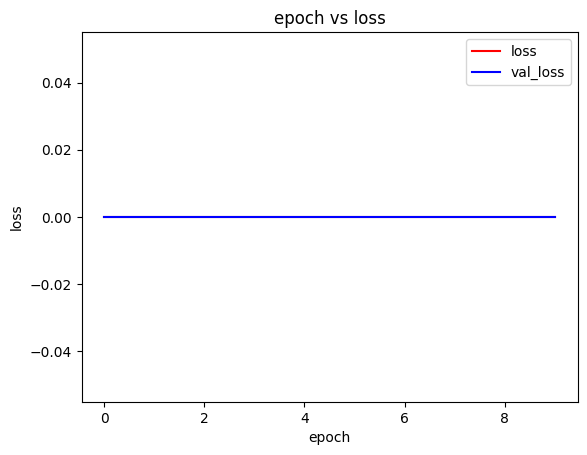

In [48]:
loss = np.array(CNN3.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN3.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
plt.show()

In [49]:
class Max_pooling():
    
    def __init__(self, stride_h, stride_w):
        self.h = stride_h
        self.w = stride_w
        self.max_pos = 0
        self.backward_map = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, ch, h, w)
        """
        batch_size = X.shape[0]
        ch_size = X.shape[1]
        h_size = X.shape[2]
        w_size = X.shape[3]
        
        output_size_h = (int)(h_size / self.h) 
        output_size_w = (int)(w_size / self.w)
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        self.backward_map = np.zeros((batch_size, ch_size, output_size_h, output_size_w, self.h, self.w))
        
        for n_h in range(output_size_h):
            for n_w in range(output_size_w):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w

                tmp = np.average(np.average(X[:,:, pos_h1:pos_h2, pos_w1:pos_w2], axis=3), axis=2)
                output[:,:, n_h, n_w] = tmp
                tmp = tmp[:,:,np.newaxis,np.newaxis]
                self.backward_map[:,:, n_h, n_w] = (X[:,:, pos_h1:pos_h2, pos_w1:pos_w2] == tmp)
                
        self.backward_map = self.backward_map.astype(int)
        
        return output
        
    def backward(self, dA):
        """
        dA.shape (batch_size, ch, h, w)
        """        
        batch_size = dA.shape[0]
        ch_size = dA.shape[1]
        h_size = dA.shape[2]
        w_size = dA.shape[3]
        
        output_size_h = h_size * self.h
        output_size_w = w_size * self.w
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        for n_h in range(h_size):
            for n_w in range(w_size):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w                    
                   
                tmp = dA[:,:, n_h, n_w][:,:, np.newaxis, np.newaxis]
                output[:,:, pos_h1:pos_h2, pos_w1:pos_w2] = tmp * self.backward_map[:,:, n_h, n_w]

        return output